In [1]:
import math
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {v:k+1 for k,v in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [3]:
def build_dataset(block_size, words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for char in w + '.':
            X.append(context)
            Y.append(stoi[char])
            context = context[1:] + [stoi[char]]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# train, dev, test split - 80%, 10%, 10%
random.seed(42)
random.shuffle(words)
train_len = int(0.8*len(words))
dev_len = int(0.9*len(words))
train = words[:train_len]
dev = words[train_len:dev_len]
test = words[dev_len:]

block_size = 3   # context length : how many chars taken to predict the next one
X_tr, Y_tr = build_dataset(block_size,train)
X_d, Y_d = build_dataset(block_size,dev)
X_t, Y_t = build_dataset(block_size,test)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP

n_embd = 10  # dimensionality of the embedding vector
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator = g) * (5/3) / ((block_size*n_embd)**0.5)# * 0.2   # tanh saturation issue
b1 = torch.randn(n_hidden, generator=g) * 0.01           # tanh saturation issue
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01    # make less confidently wrong
b2 = torch.randn(vocab_size, generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print('number of parameters: ',sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters:  11897


In [98]:
# optimization

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #mini batch construct
    ix = torch.randint(0, X_tr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_tr[ix], Y_tr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  #embed chars into vectors (replacement of one hot encoding did in prev approaches)
    embcat = emb.view(emb.shape[0],-1) 
    hpreact = embcat @ W1 + b1  # hidden layer pre activation 
    h = torch.tanh(hpreact)   # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)   #loss function

    # backward layer
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 ==0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break   # check things at initialization, steps done below
    


0/200000 : 3.3179
10000/200000 : 2.1910
20000/200000 : 2.3270
30000/200000 : 2.5396
40000/200000 : 1.9468
50000/200000 : 2.3331
60000/200000 : 2.3852
70000/200000 : 2.1173
80000/200000 : 2.3159
90000/200000 : 2.2010
100000/200000 : 1.8591
110000/200000 : 2.0881
120000/200000 : 1.9389
130000/200000 : 2.3913
140000/200000 : 2.0949
150000/200000 : 2.1458
160000/200000 : 1.7824
170000/200000 : 1.7249
180000/200000 : 1.9751
190000/200000 : 1.8614


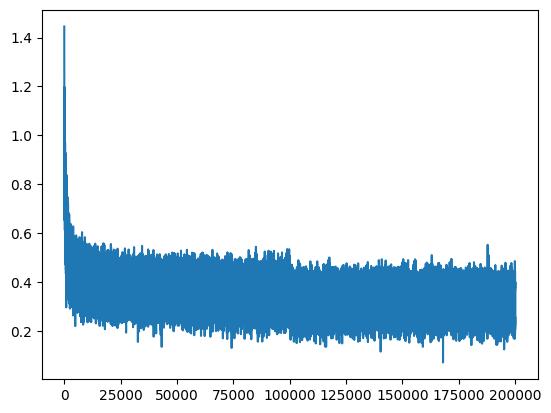

In [49]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {'train':(X_tr, Y_tr),
        'val':(X_d, Y_d),
        'test':(X_t, Y_t)}[split]
    
    emb = C[x]
    embcat = emb.view(x.shape[0],-1)
    h =  torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(f'{split} : {loss.item():.4f}')

split_loss('val')
split_loss('test')

# original :
# val : 2.1688
# test : 2.1570

# after fixing softmax being confidently wrong(initialization fix) and fixing tanh layer too saturated 
# at init :
# val : 2.1027
# test : 2.1012

# with kaiming init values for W1
# val : 2.1070
# test : 2.1050


val : 2.1070
test : 2.1050


In [55]:
# sample from model
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = ''
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out += itos[ix]
        if ix==0:
            break
    print(out)

dexze.
moallurailah.
tyha.
maliston.
anra.
ade.
kaida.
samiyah.
jaxsi.
gotti.
moriella.
kinzored.
akaley.
masidgh.
akavion.
rysley.
hani.
gavtarlyn.
kashra.
anell.


Now there are issues in this network, the initialization isn't good.
The loss at initialization is way too high than expected loss
loss@0 is 0/200000 : 27.8817 but at initialization we can expect uniform distribution as there isn't any reason why some chars would be much more likely
so expected loss is -torch.tensor(1/27).log() = 3.2958

In [ ]:
logits[0]  # numbers are extreme so we need to try to make them as close to 0 
 # logits  = h @ W2 + b2 so b2 can be 0 and W2 can be scaled like by 0.1, 0.01, 1 

tensor([ 9.7570, 10.1561,  1.1321,  4.8603,  3.3942, 10.2756,  0.7673, -0.6371,
         0.6018,  9.4076,  0.7465,  1.4101,  3.8462,  4.4742,  4.2583,  8.7584,
        -2.0530, -9.0507,  2.4433,  6.7215,  2.6099,  5.3056, -0.7323, -0.3857,
        -3.5226,  9.0652,  4.0579], grad_fn=<SelectBackward0>)

In [ ]:
# b2 = 0 and W2 scaled by 0.1  
# loss recorded at initialization is 4.2, closer to what we expect
logits[0]

tensor([-0.2490,  3.5232, -1.2675,  0.5407,  1.6622, -1.1708, -0.1398,  0.1242,
         0.9210,  1.1347,  1.3624, -0.9252,  0.4438, -2.4594, -0.9714,  0.1247,
        -0.9572, -1.3763, -2.3287, -0.1374,  2.4522,  1.6165,  1.6649, -1.0944,
        -2.1544,  0.7255,  1.1413], grad_fn=<SelectBackward0>)

In [ ]:
# b2 = 0 and W2 scaled by 0.01
# loss recorded at initialization is 3.3, much closer to what we expect (3.29)
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

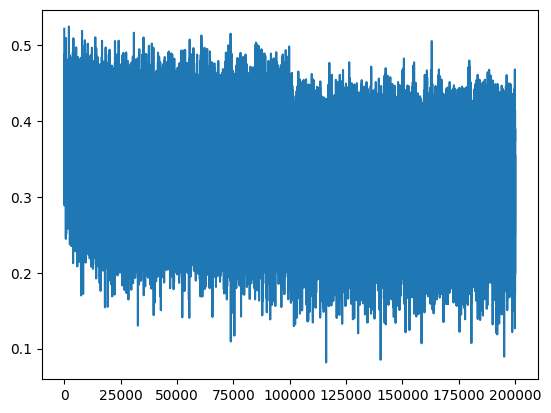

In [66]:
# for full run at W2 scaled by 0.01 and b2=0 loss recorded isn't a hockey stick shape now as compared 
# to before in the above plot

plt.plot(lossi)

now the second problem here is logits are now fine but the problems are with the values of h (the activations of the hidden state) 
tanh > squashes the values to be between 1 and -1

let's check the values of h at initialization. 
NOTE : the below statements are checking for the values of h at initialization and not after complete run

In [ ]:
h  # many values are 1 or -1 here

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

torch.Size([32, 200])


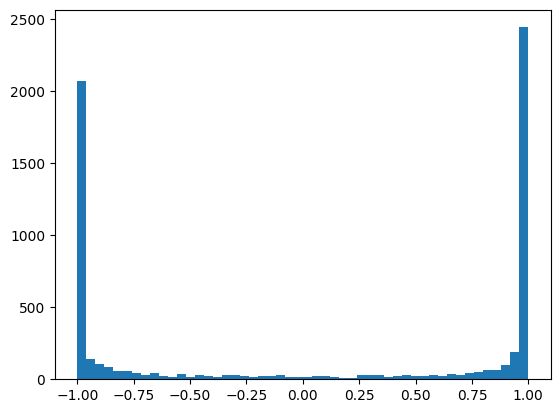

In [ ]:
# let's plot to see the distribution
print(h.shape)

# create a list and plot
plt.hist(h.view(-1).tolist(), bins = 50);

# most of values this takes are 1 and -1 so the tanh is very active

# too saturated

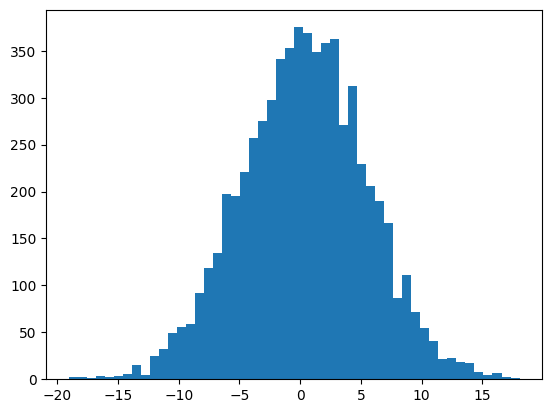

In [ ]:
#let's look at the preactivation feeded to tanh

plt.hist(hpreact.view(-1).tolist(),bins=50);

# its very broad, numbers being from -15 to 15 so everything is kind of squashed

def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

the problem is with many tanh values being 1 and -1 the grad for tanh becomes 0 as t would be 1 or -1 so (1 - t**2) would be 0 making grad 0 for any value of out.grad. killing the grad and stopping the backprop through the tanh unit

if t is 0 i.e. the tanh is sort of inactive then the gradient just passes through

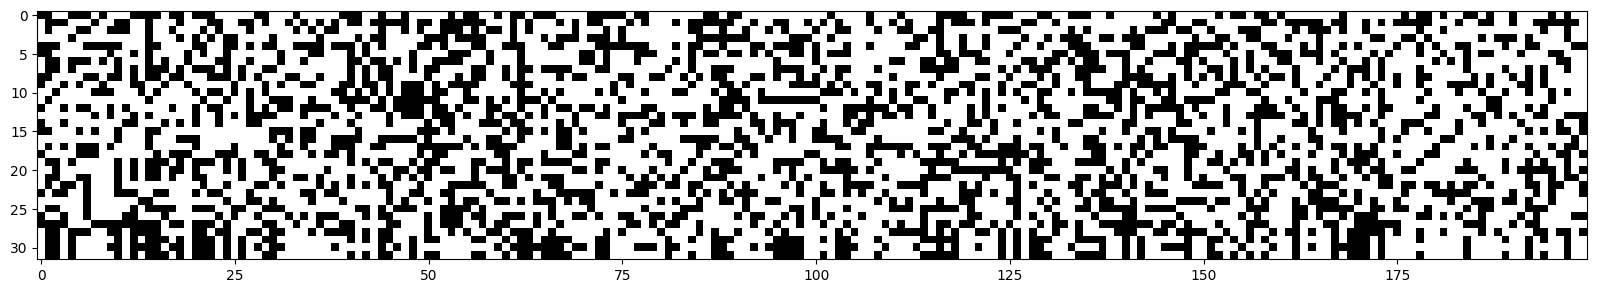

In [ ]:
# let's see how often the value is in tail i.e. 1 or -1, the white pixel in the plot
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

# all these white pixels(tanh neurons) are in tail and are active and the backward gradient would be destroyed
# a lot of trouble would be if an entire column is white i.e. the initialization of weights and biases is such that 
# no single example ever activates tanh in the active part of tanh, the neurons would never learn and 
# is called dead neuron

# same will be true for other activation functions as well: sigmoid, ReLU, 
# Leaky Relu won't suffer much as it doesn't has flat tails

# this can happen during initialization and optimization as well(high learning rate)

to fix it :
hpreact = embcat @ W1 + b1  # hidden layer pre activation 
h = torch.tanh(hpreact)   # hidden layer

hpreact is too far from from 0 and that is causing the issue. make it closer to 0 as done with logits
scale W2 and b2 by small numbers like 0.01 to have some entropy so that there is a little bit of diversity in the tanh neurons (helps optimization)


lets check the plots after scaling  W1 by 0.1 and b1 by 0.01

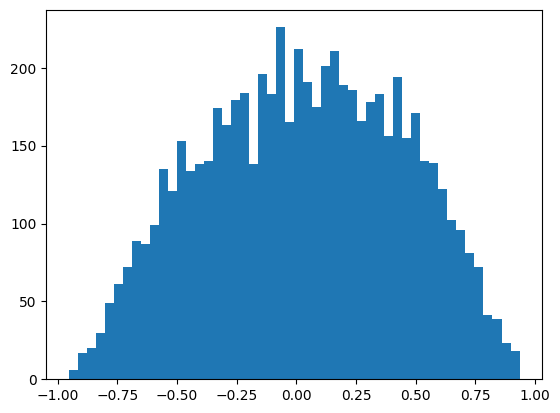

In [ ]:
plt.hist(h.view(-1).tolist(),bins=50);

# nothing is 1 or -1

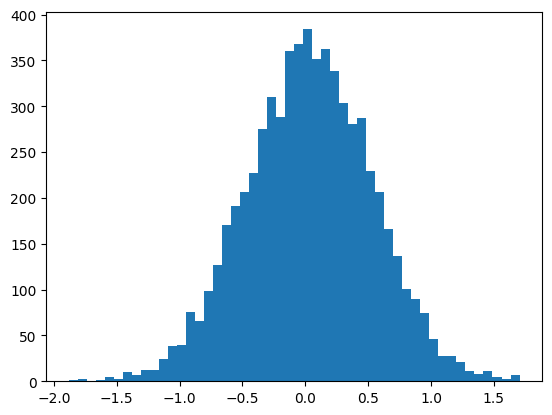

In [ ]:
plt.hist(hpreact.view(-1).tolist(),bins=50);
# no wide spread noticed as before

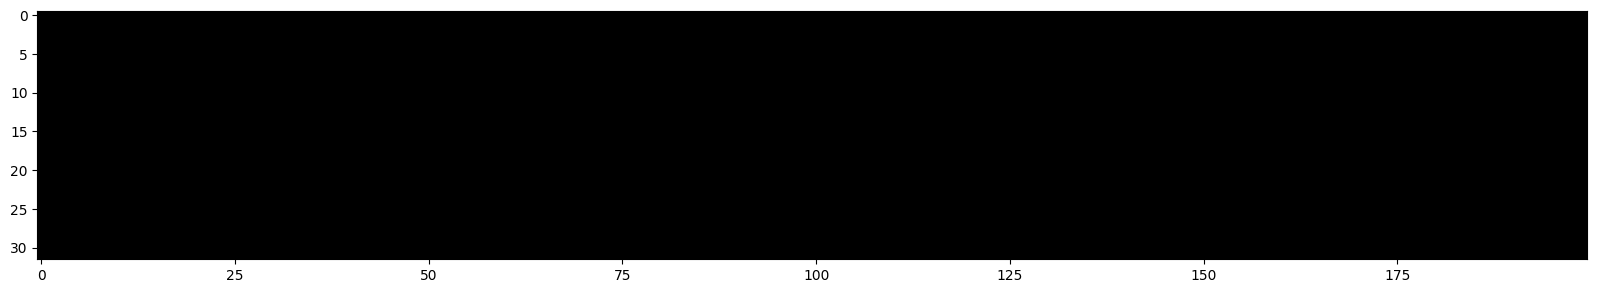

In [ ]:
# let's see how often the value is in tail i.e. 1 or -1
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

lets check the plots after scaling  W1 by 0.2 and b1 by 0.01 at initialization

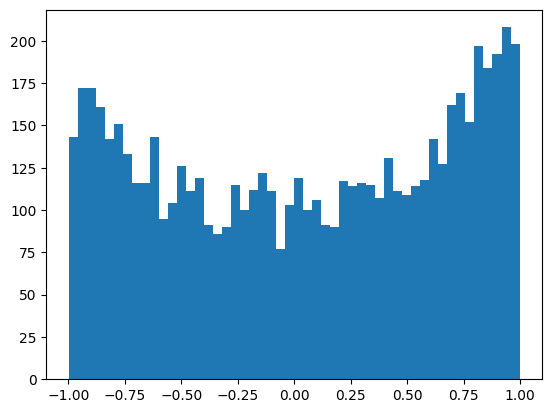

In [ ]:
plt.hist(h.view(-1).tolist(),bins=50);

# few values are 1 or -1

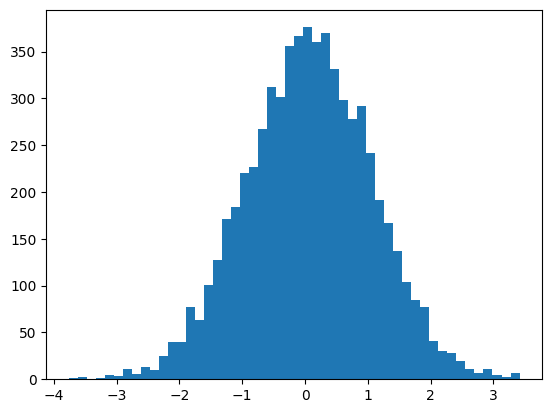

In [91]:
plt.hist(hpreact.view(-1).tolist(),bins=50);
# no wide spread noticed as before

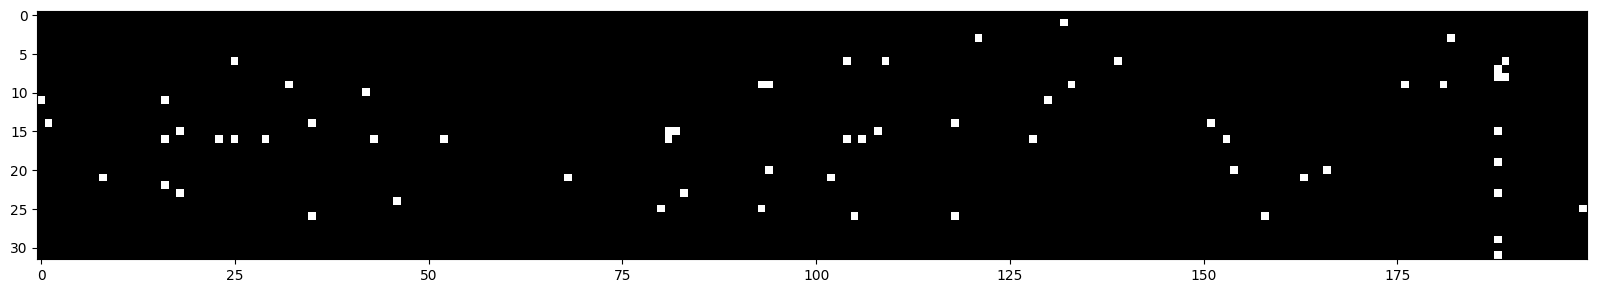

In [90]:
# let's see how often the value is in tail i.e. 1 or -1
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

Now how do we get to these magic numbers(used to scale the W, B)?
https://arxiv.org/pdf/1502.01852 
https://docs.pytorch.org/docs/stable/nn.init.html

even if the initialization is not precise these modern day innovations can help - residual connections, batch, layer normalization, optimizers like adam, rms 
in practice normalize by square root of fan in

torch.nn.init.kaiming_normal_
here for tanh non linearity the value can be calculated as (5/3) / (fan_mode**0.5)

In [ ]:
(5/3)/(30**0.5)  # fan_mode: fan_in - number of inputs = 30 for W1

# we randomly guessed 0.2, close to this 0.30

0.3042903097250923

batch normalization: https://arxiv.org/pdf/1502

motivation: in hidden states: hpreact we don't want the preactivation states to be way too small because then the tanh won't do anything or we don't want them to be too big otherwise the tanh would be saturated. we want it roughly gaussian i.e. 0 mean and unit std atleast at init. 
insight from the paper: then why not take the hidden states and normalize them to be unit gaussian.

we want these to be roughly gaussian but only at init but we don't want to force them to be unit gaussian always, we want it to move around to be more diffused or sharped based on the backprop so we scale and shift. normalize then scale by some gain and offset by some bias. epsilon in normalize is to avoid the division by zero. (gain and bias - affine parameters)

adding this batch norm layers (# https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) after a linear (https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html) or a convolutional layer is easier than managing the scales for Ws or Bs using kaiming for deeper networks. also in those layers remove bias as its kind of subtracted while normalizing and the grads of bias becomes 0. Its just wasteful. bnbias (batch normalization bias) is the incharge here of biasing the distribution

though it comes with a cost. as we are normalizing over a batch we are coupling inputs mathematically in the fw and bw pass. the hidden state activations are not just the function of that example but of all the examples that are selected randomly in the batch but it kind of works and can be thought of as regularizer as it kind of makes it harder to overfit because of all the jitter introduced. 
other options are layer, instance, group normalizations to avoid this coupling

In [104]:
print(hpreact.shape)
print(hpreact.mean(0,keepdim=True).shape)
print(hpreact.std(0,keepdim=True).shape)

torch.Size([32, 200])
torch.Size([1, 200])
torch.Size([1, 200])


In [ ]:
# MLP

n_embd = 10  # dimensionality of the embedding vector
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator = g) * (5/3) / ((block_size*n_embd)**0.5)# * 0.2   # tanh saturation issue
# b1 = torch.randn(n_hidden, generator=g) * 0.01           # tanh saturation issue
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01    
b2 = torch.randn(vocab_size, generator=g) * 0 

bngain = torch.ones((1, n_hidden))  # batch normalization gain
bnbias = torch.zeros((1, n_hidden))  # batch normalization bias

# at init we are having the pre act layer as unit gaussian so the mean and std would be 0 and 1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden)) 

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print('number of parameters: ',sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters:  12297


In [ ]:
# optimization

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #mini batch construct
    ix = torch.randint(0, X_tr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_tr[ix], Y_tr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  #embed chars into vectors (replacement of one hot encoding did in prev approaches)
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors

    #linear layer # https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html
    hpreact = embcat @ W1 # + b1  # hidden layer pre-activation

    # batchnorm layer # https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
    bmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bmeani / bnstdi) + bnbias
    with torch.no_grad():
        # these would be roughly what they are with small updates in the direction of the current value
        # these 0.001 are called momentum. since the batch size here is small it is kept as 0.001 so that if the mean/std are thrashing too much it won't affect much and would converge
        # for larger batch sizes the mean would be consistent so keeping momentum as 0.1 would be fine as well
        bnmean_running = 0.999* bnmean_running + 0.001* bmeani
        bnstd_running = 0.999* bnstd_running + 0.001* bnstdi

    
    # non linearity
    h = torch.tanh(hpreact)   # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)   #loss function

    
    # backward layer
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 ==0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break   # check things at initialization, steps done below
    


0/200000 : 3.3153
10000/200000 : 2.1706
20000/200000 : 2.3339
30000/200000 : 2.5143
40000/200000 : 1.9491
50000/200000 : 2.3896
60000/200000 : 2.3723
70000/200000 : 2.0383
80000/200000 : 2.3944
90000/200000 : 2.1295
100000/200000 : 1.8097
110000/200000 : 2.2099
120000/200000 : 1.9458
130000/200000 : 2.3309
140000/200000 : 2.2505
150000/200000 : 2.2001
160000/200000 : 1.8520
170000/200000 : 1.7781
180000/200000 : 1.9428
190000/200000 : 1.8188


In [114]:
b1.grad

tensor([ 8.3242e-03, -5.1822e-03, -1.4961e-03,  7.2440e-03,  2.3155e-03,
        -3.2621e-03,  3.0395e-04, -1.3793e-02,  4.8726e-03,  1.1413e-02,
        -5.3736e-03,  5.8891e-03, -2.9187e-03, -4.2755e-03, -5.4400e-03,
        -1.9361e-02,  1.9354e-03, -5.0041e-03, -1.5655e-03,  1.1650e-02,
         1.9095e-02,  6.8849e-03,  6.0871e-03,  3.8677e-03, -5.2383e-03,
         5.7836e-04,  5.2632e-03,  1.0343e-02, -1.0085e-03, -5.6645e-03,
         5.6666e-03,  1.0320e-02,  3.3560e-03,  4.8115e-03,  5.4514e-03,
         3.3869e-03,  3.8442e-03, -1.0950e-02,  1.8323e-02,  7.4713e-04,
         3.0944e-03,  1.9975e-03,  1.7304e-03, -6.3366e-03, -5.3639e-03,
        -1.6090e-03,  4.2961e-03,  8.7163e-03,  2.2214e-03,  9.1405e-03,
         4.2719e-04,  1.0767e-02,  4.9942e-03,  5.3845e-03, -6.3157e-03,
         1.3954e-04, -6.5262e-04,  4.8062e-03, -9.9278e-03,  2.6595e-03,
         6.3882e-03,  7.6970e-03, -6.8435e-03,  9.2689e-03, -1.8704e-02,
         2.9133e-03,  6.8612e-03,  4.2175e-03, -1.3

inference? how do we feed a single example and get the output (if a model is deployed in prod)? as it now expects batch for bnbias and bngain.

In [ ]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    emb = C[X_tr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1

    # measure mean, std over entire training set

    bmean = hpreact.mean(0, keepdim=True)
    bstd = hpreact.std(0, keepdim=True)


# this can also be estimated in a running manner during training of the network and is usually done that way


In [ ]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {'train':(X_tr, Y_tr),
        'val':(X_d, Y_d),
        'test':(X_t, Y_t)}[split]
    
    emb = C[x]
    embcat = emb.view(x.shape[0],-1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bmean /  bstd) + bnbias
    # hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True) /  hpreact.std(0,keepdim=True)) + bnbias
    h =  torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(f'{split} : {loss.item():.4f}')

split_loss('val')
split_loss('test')

# batch norm (calibrated):
# val : 2.1086
# test : 2.1085

# batch norm (running stats):
# val : 2.1087
# test : 2.1085



val : 2.1087
test : 2.1085


Pytorchified

training a deeper network

In [4]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out),generator=g) / (fan_in ** 0.5)   # div by sqrt of fan_in can be optional with batchnorm
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps = 1e-5):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # batch normalization gain
        self.beta = torch.zeros(dim) # batch normalization bias
    
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)    # batch variance
        else:     # test or inference
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar+self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta   # scale and shift

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

without batchnorm layers

In [66]:
n_hidden = 100
n_embd = 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [ 
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
        ]

with torch.no_grad():
    # last layer: make softmax less confident
    layers[-1].weight *= 0.1

    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # different values to check the first hist plot 0.5, 1, 3, 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Number of total parameters: ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


Number of total parameters:  46497


In [ ]:
lossi=[]
batch_size = 32
max_steps = 200000
ud = []  # update to data ratio (stat to plot and check the update done to data)
for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0, X_tr.shape[0],(batch_size, ), generator=g)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # forward pass
    emb = C[Xb]   # embed the characters
    x = emb.view(emb.shape[0],-1)  #concatenate

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # DEBUG : remove later
    
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    # if i>1000:
    break # DEBUG (visualizations below): remove later



0/200000 : 3.2962


Visualizations - miscalibrations of nn can be checked

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


C:\Users\kchan\AppData\Local\Temp\ipykernel_10628\1397477801.py:7: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

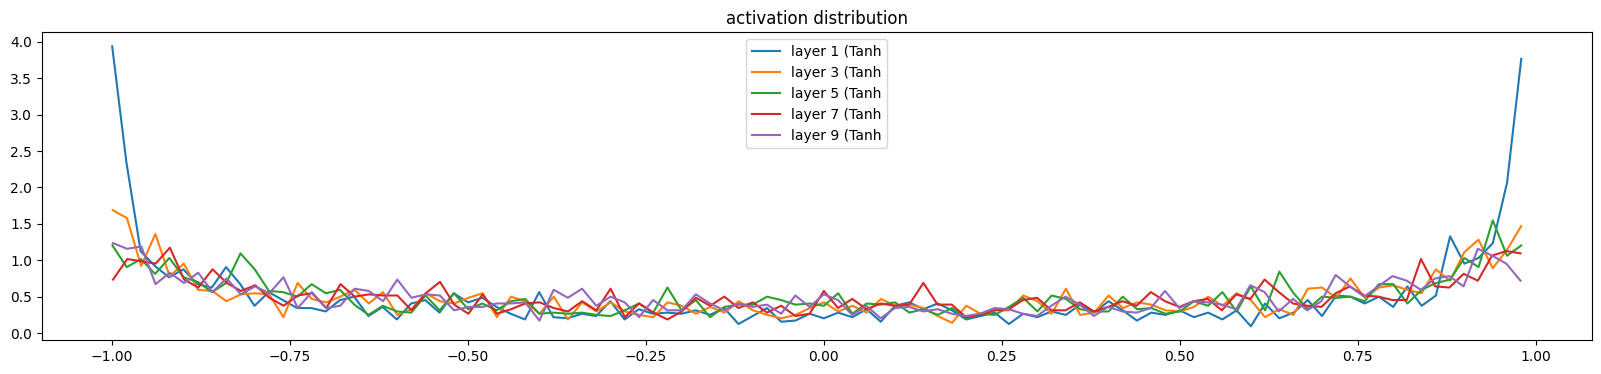

In [ ]:
# visualize histograms

# gain 5/3
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

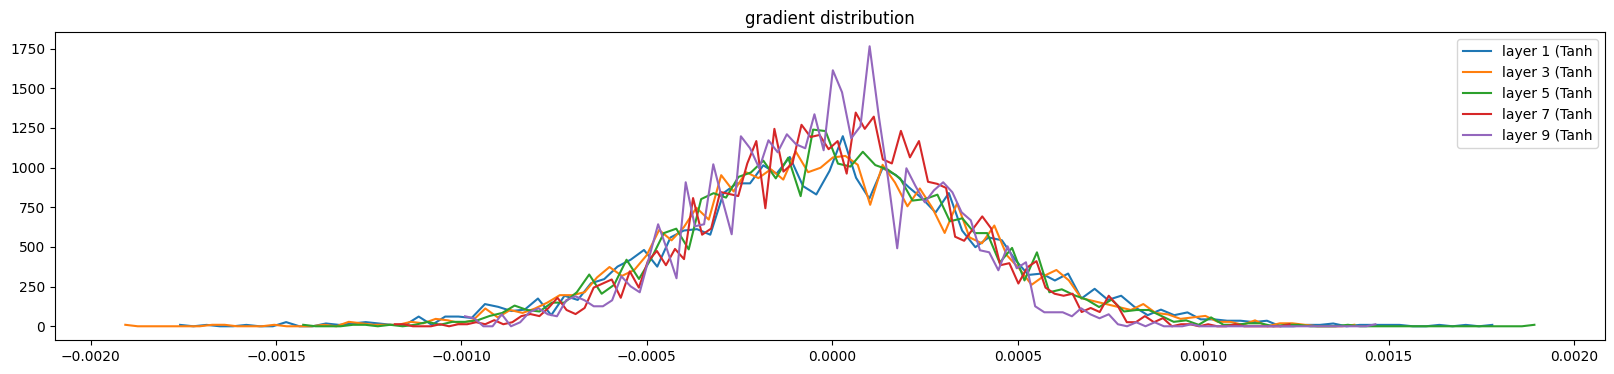

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

# all of the different layers in this sandwich have roughly same gradient they aren't shrinking/exploding

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


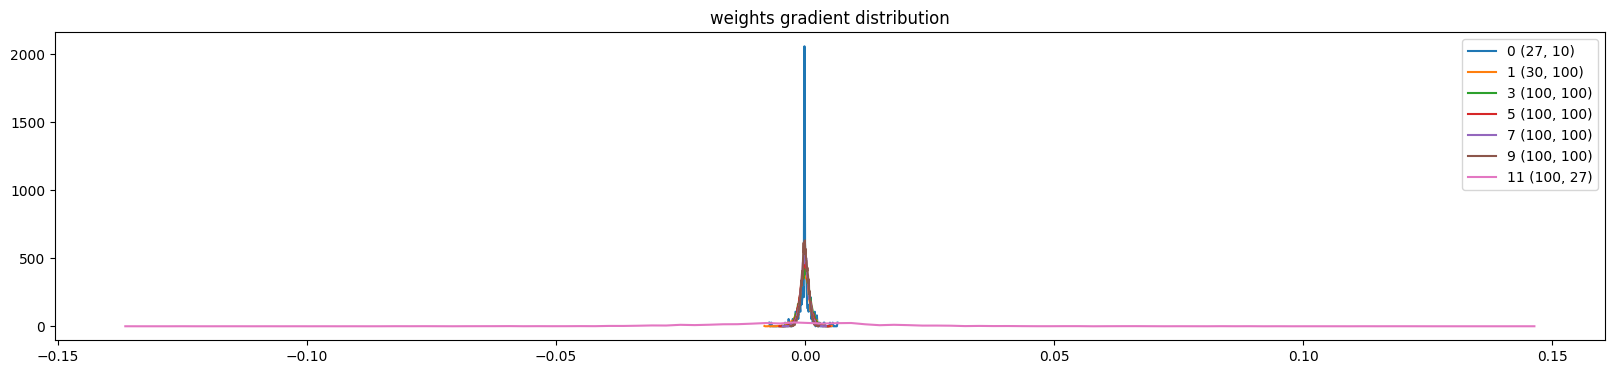

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:   # keeping only weights, skipped biases, gammas, betas
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# even though the above 2 plots are fine, this isn't. as we are taking step update if the grad is
# bigger than the data then it is problematic as the last layer is optimizing faster than other layers 
# at init. this can be fixed if /trained for longer

weight   (27, 10) | mean +0.000772 | std 9.714615e-03 | grad:data ratio 9.714500e-03
weight  (30, 100) | mean -0.000036 | std 8.734046e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424626e-03 | grad:data ratio 4.417371e-02
weight (100, 100) | mean +0.000055 | std 6.242014e-03 | grad:data ratio 3.681918e-02
weight (100, 100) | mean +0.000007 | std 6.161664e-03 | grad:data ratio 3.650615e-02
weight (100, 100) | mean +0.000069 | std 5.221999e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229574e-01


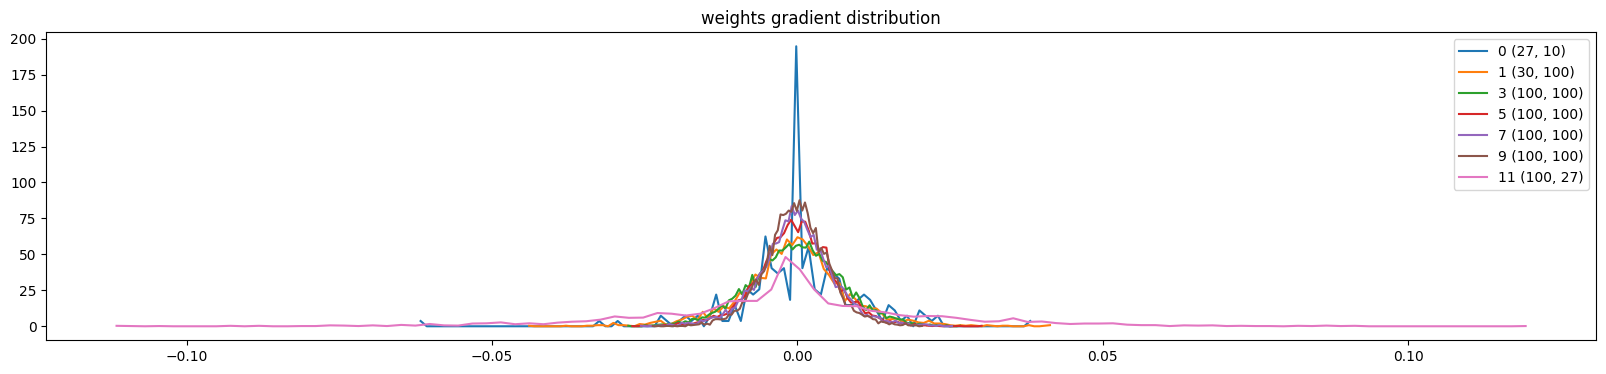

In [ ]:
# looped till i==1000
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:   # keeping only weights, skipped biases, gammas, betas
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# we can see it is getting stable as it is trained. using adam optimizer than stochastic gradient is preferred

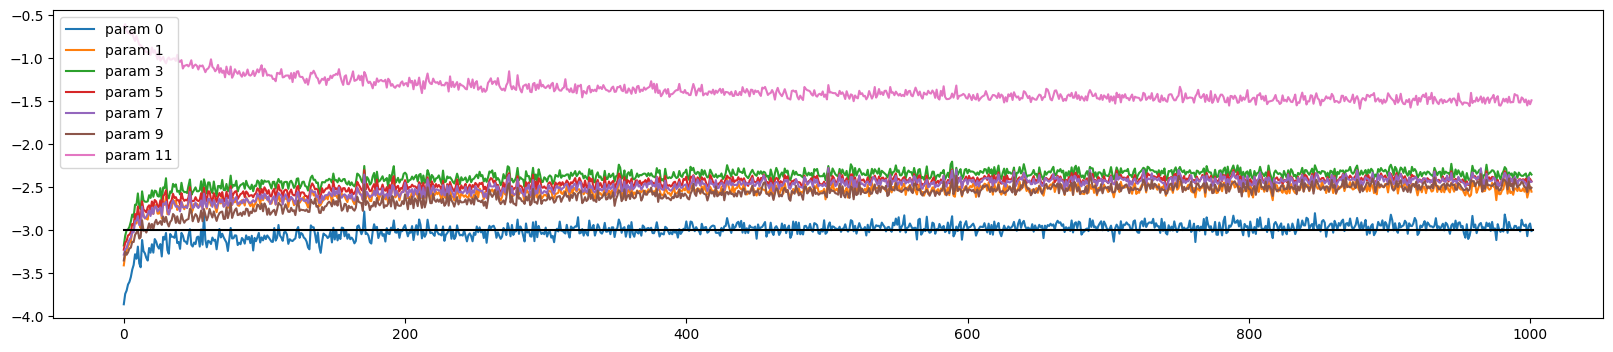

In [ ]:
# plotted with lr = 0.1 for 1000 iter
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# if its below -3 on this log plot then it means we aren't learning fast i.e. lr is low. over here its 
# above -3 but its stabilizing well so its kind of decent settings. the param 11 (output layer) is made 
# less confident (weights multiplied by 0.1) in the settings above so it starts of this way but stabilizes well once the weights starts to learn.

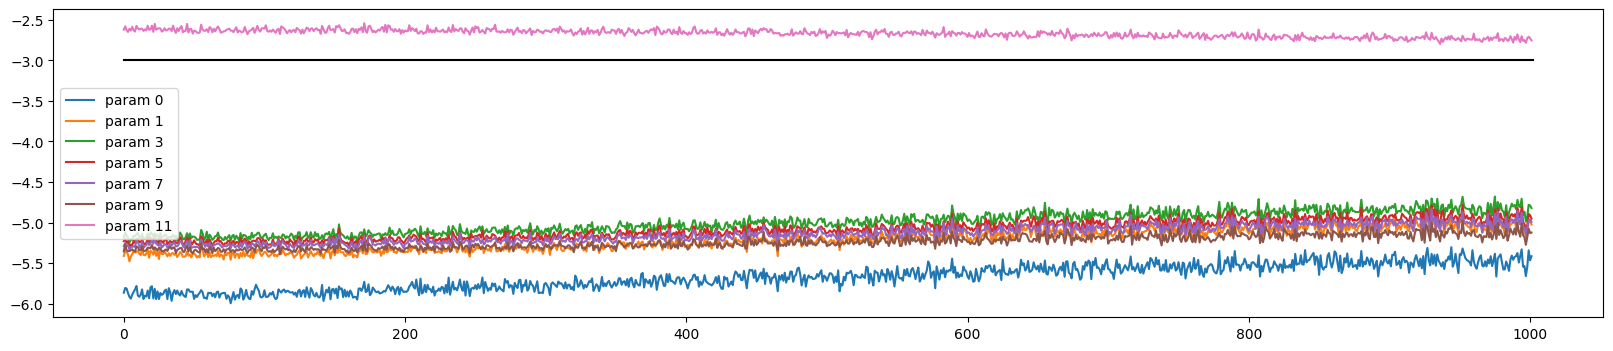

In [ ]:
# plotted with lr = 0.001 for 1000 iter
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# the updates done are way too small, need to change the lr

Visualize by keeping the gain as 1

layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

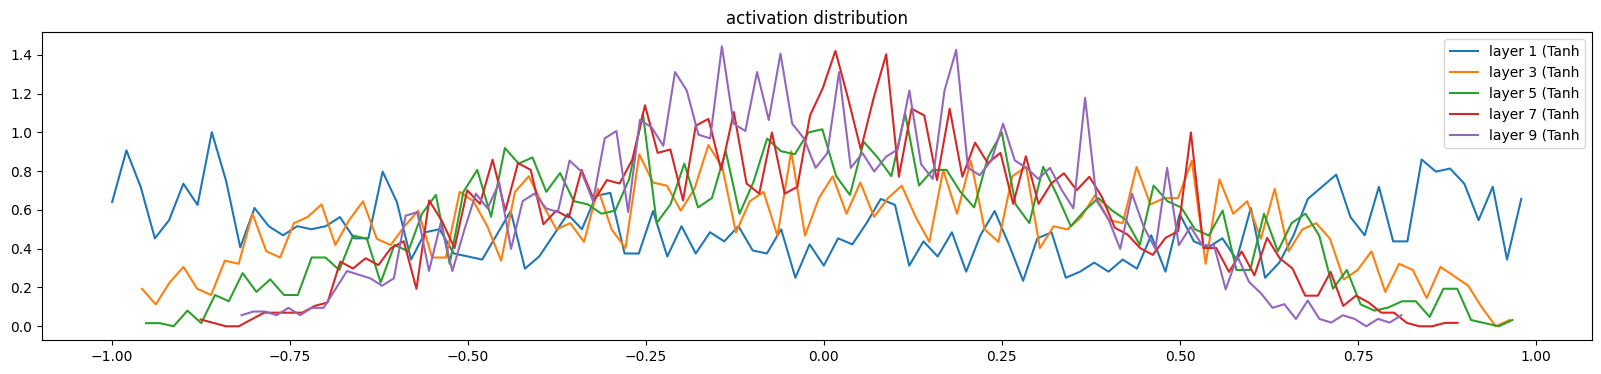

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# started getting squashed to 0 after layer 1

Visualize by keeping the gain as 0.5

layer 1 (      Tanh): mean -0.01, std 0.41, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.20, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.10, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.05, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

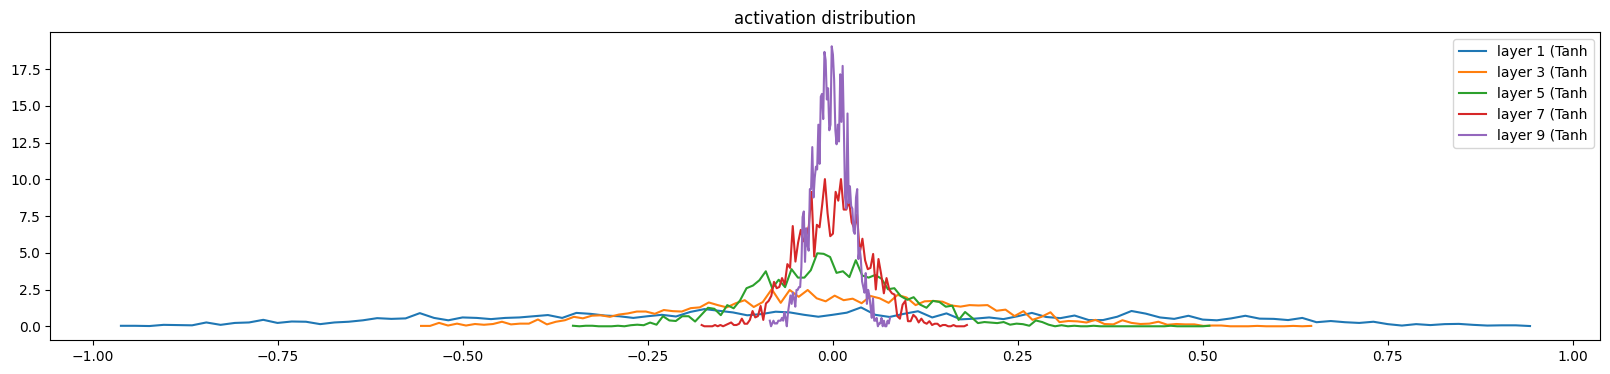

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# activations shrinking to 0 

layer 1 (      Tanh): mean +0.000000, std 1.892402e-05
layer 3 (      Tanh): mean -0.000001, std 3.943546e-05
layer 5 (      Tanh): mean +0.000004, std 8.035369e-05
layer 7 (      Tanh): mean +0.000009, std 1.561152e-04
layer 9 (      Tanh): mean -0.000014, std 3.053498e-04


Text(0.5, 1.0, 'gradient distribution')

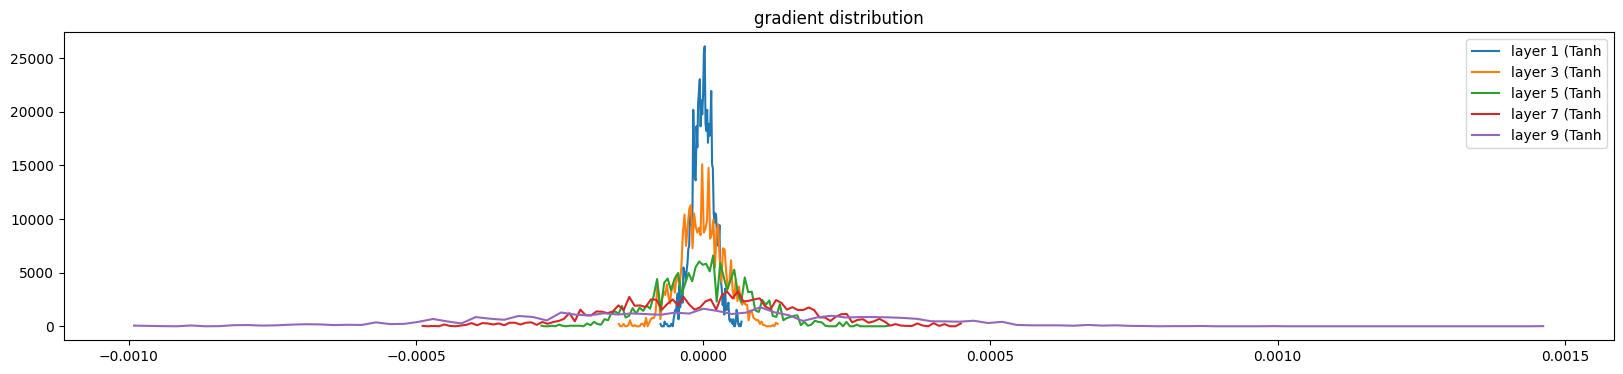

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

# gradients are expanding

Visualize by keeping the gain as 3

layer 1 (      Tanh): mean -0.03, std 0.85, saturated: 47.66%
layer 3 (      Tanh): mean +0.00, std 0.84, saturated: 40.47%
layer 5 (      Tanh): mean -0.01, std 0.84, saturated: 42.38%
layer 7 (      Tanh): mean -0.01, std 0.84, saturated: 42.00%
layer 9 (      Tanh): mean -0.03, std 0.84, saturated: 42.41%


Text(0.5, 1.0, 'activation distribution')

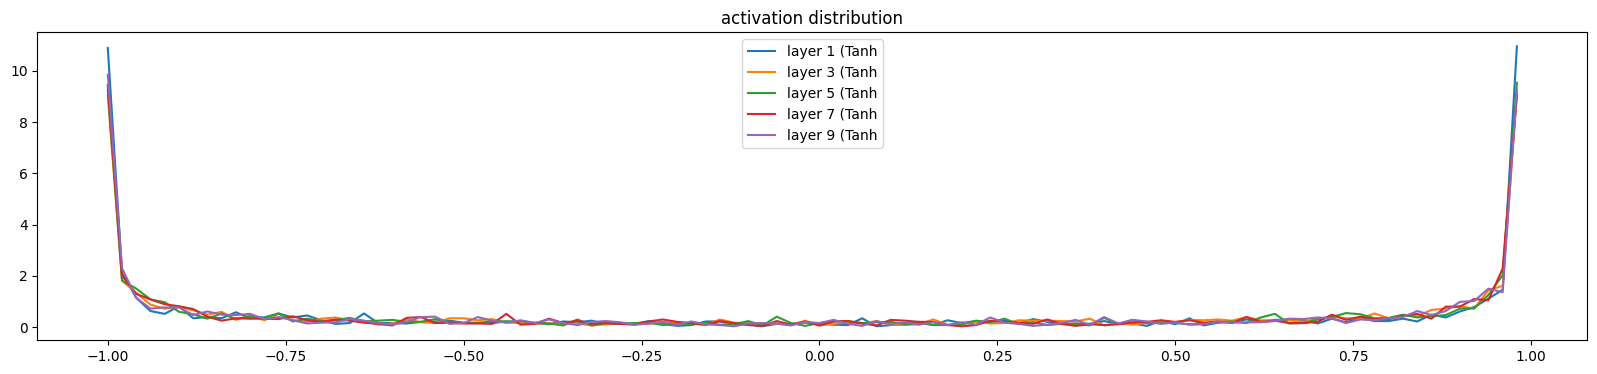

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# very saturated

layer 1 (      Tanh): mean -0.000001, std 9.977492e-04
layer 3 (      Tanh): mean +0.000010, std 7.421208e-04
layer 5 (      Tanh): mean +0.000003, std 5.569782e-04
layer 7 (      Tanh): mean +0.000017, std 3.952166e-04
layer 9 (      Tanh): mean -0.000014, std 3.051525e-04


Text(0.5, 1.0, 'gradient distribution')

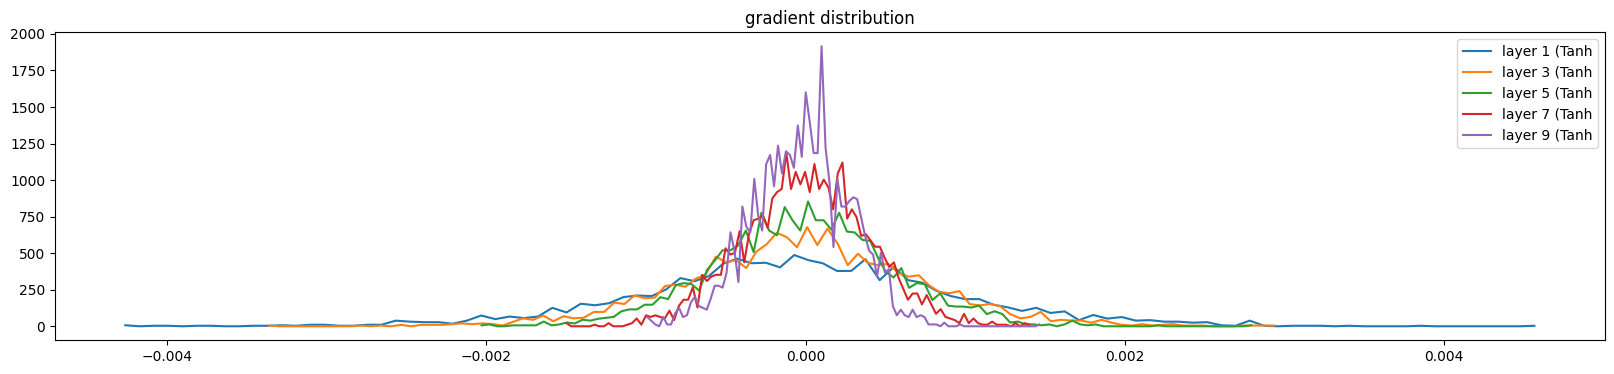

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

# gradients are assymetric - changes as we go deeper in the layers

so without using batchnorm need to set the gain carefully to get nice activations in both the fw and bw passes as seen in the plots above

let's plot when the network is a sandwich of only linear layers for gain 5/3

layer 0 (    Linear): mean -0.04, std 1.65, saturated: 55.12%
layer 1 (    Linear): mean -0.04, std 2.72, saturated: 71.78%
layer 2 (    Linear): mean -0.00, std 4.67, saturated: 81.31%
layer 3 (    Linear): mean +0.09, std 7.50, saturated: 91.19%
layer 4 (    Linear): mean -0.72, std 12.78, saturated: 93.69%


Text(0.5, 1.0, 'activation distribution')

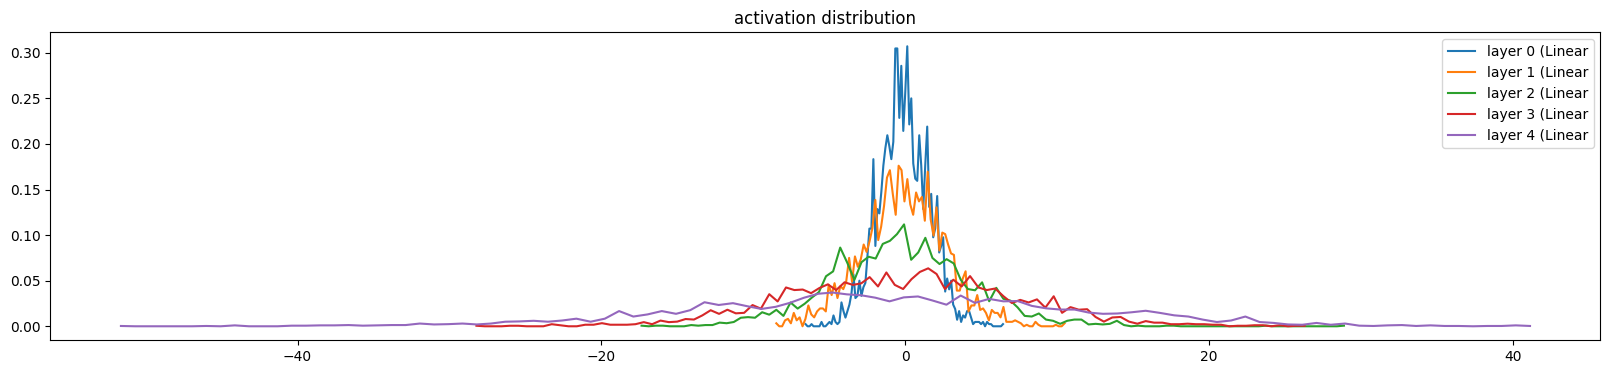

In [50]:

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# activations have diffused going deeper into the network

layer 0 (    Linear): mean +0.000053, std 2.619184e-03
layer 1 (    Linear): mean -0.000006, std 1.583188e-03
layer 2 (    Linear): mean +0.000043, std 9.519162e-04
layer 3 (    Linear): mean +0.000019, std 5.457934e-04
layer 4 (    Linear): mean -0.000013, std 3.161244e-04


Text(0.5, 1.0, 'gradient distribution')

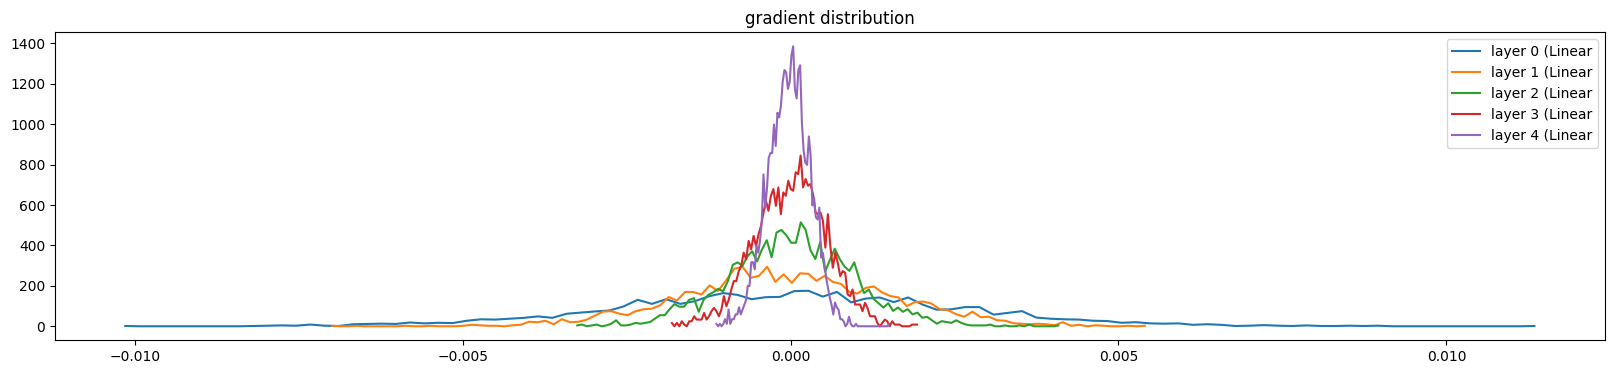

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):   
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

# gradients are diminishing going deeper into the network

let's plot when the network is a sandwich of only linear layers for gain 1

layer 0 (    Linear): mean -0.02, std 0.99, saturated: 32.16%
layer 1 (    Linear): mean -0.01, std 0.98, saturated: 31.12%
layer 2 (    Linear): mean -0.00, std 1.01, saturated: 31.16%
layer 3 (    Linear): mean +0.01, std 0.97, saturated: 31.66%
layer 4 (    Linear): mean -0.06, std 0.99, saturated: 32.47%


Text(0.5, 1.0, 'activation distribution')

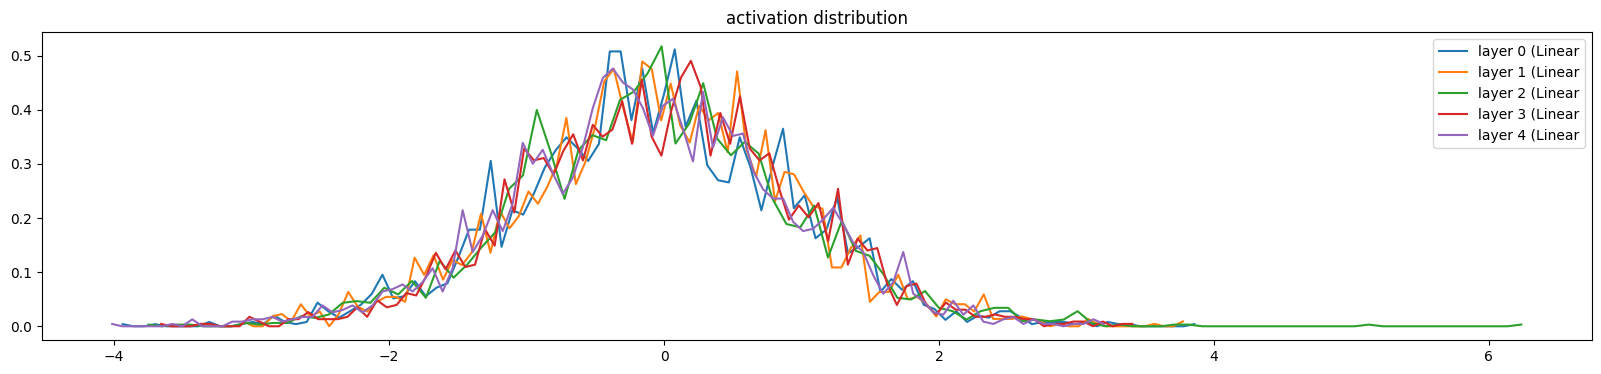

In [54]:

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# activations have diffused going deeper into the network

layer 0 (    Linear): mean +0.000005, std 3.190493e-04
layer 1 (    Linear): mean -0.000004, std 3.204010e-04
layer 2 (    Linear): mean +0.000015, std 3.229072e-04
layer 3 (    Linear): mean +0.000018, std 3.127774e-04
layer 4 (    Linear): mean -0.000014, std 3.055150e-04


Text(0.5, 1.0, 'gradient distribution')

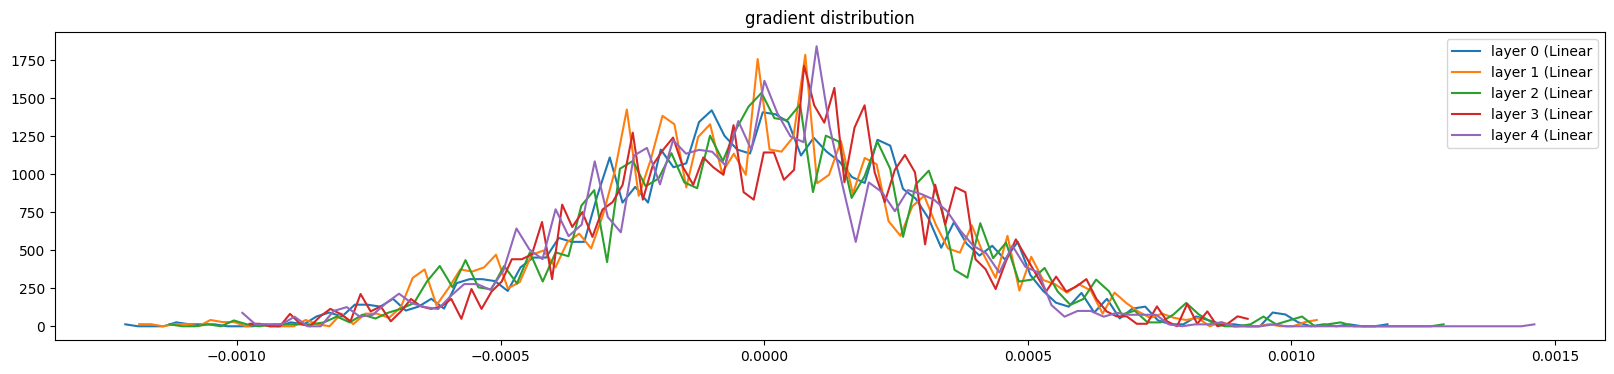

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):   
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

so the correct setting is gain = 1 in this case as the statistics are well behaved as observed in the plots above. also now this will all collapse to a linear transformation only after removing the tanh non linearity

let's place batchnorm layers

In [5]:
n_hidden = 100
n_embd = 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [ 
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
        ]

with torch.no_grad():
    # last layer: make softmax less confident
    # layers[-1].weight *= 0.1
    # now as the last layer is batchnorm, weights won't be changed. gamma would be.
    layers[-1].gamma *= 0.1

    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3  # can be 1 with batch norm

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Number of total parameters: ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


Number of total parameters:  47551


In [85]:
lossi=[]
batch_size = 32
max_steps = 200000
ud = []  # update to data ratio (stat to plot and check the update done to data)
for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0, X_tr.shape[0],(batch_size, ), generator=g)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # forward pass
    emb = C[Xb]   # embed the characters
    x = emb.view(emb.shape[0],-1)  #concatenate

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # DEBUG : remove later
    
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i>1000:
        break # DEBUG (visualizations below): remove later



0/200000 : 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

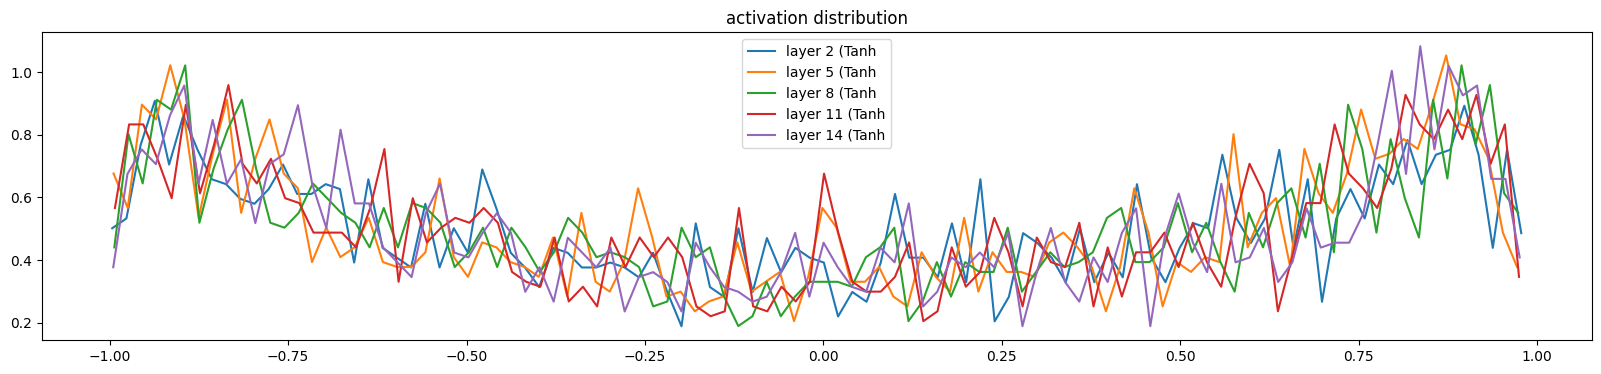

In [79]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean -0.000000, std 3.561975e-03
layer 5 (      Tanh): mean +0.000000, std 3.119523e-03
layer 8 (      Tanh): mean +0.000000, std 2.904404e-03
layer 11 (      Tanh): mean -0.000000, std 2.580223e-03
layer 14 (      Tanh): mean +0.000000, std 2.440871e-03


Text(0.5, 1.0, 'gradient distribution')

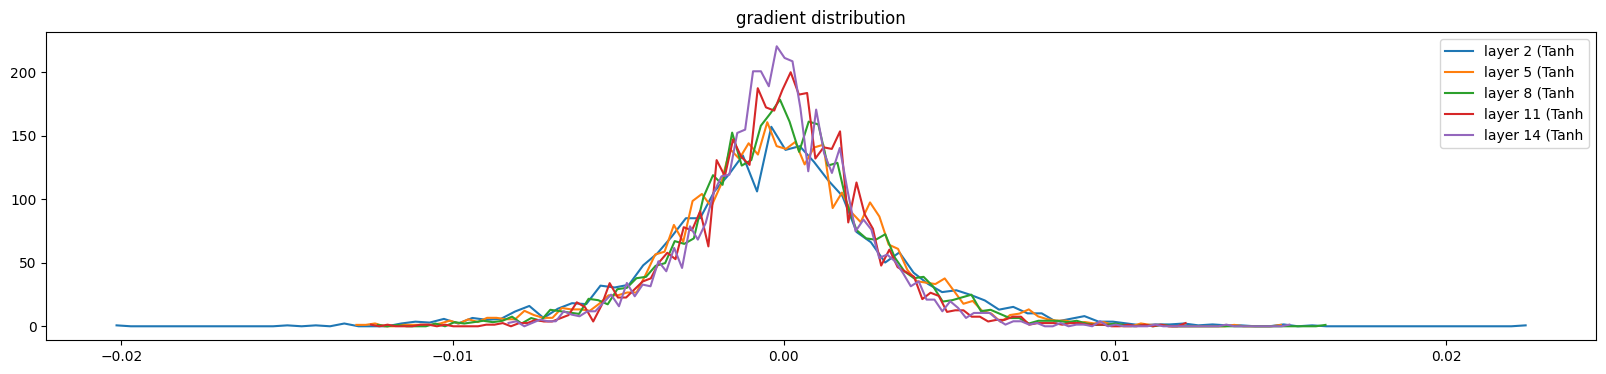

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.198642e-03 | grad:data ratio 8.190284e-03
weight  (30, 100) | mean -0.000195 | std 7.650386e-03 | grad:data ratio 2.447694e-02
weight (100, 100) | mean -0.000097 | std 6.207564e-03 | grad:data ratio 3.712871e-02
weight (100, 100) | mean +0.000015 | std 5.561915e-03 | grad:data ratio 3.297626e-02
weight (100, 100) | mean +0.000008 | std 5.220598e-03 | grad:data ratio 3.110149e-02
weight (100, 100) | mean +0.000029 | std 4.829157e-03 | grad:data ratio 2.876366e-02
weight  (100, 27) | mean -0.000014 | std 9.281207e-03 | grad:data ratio 5.568812e-02


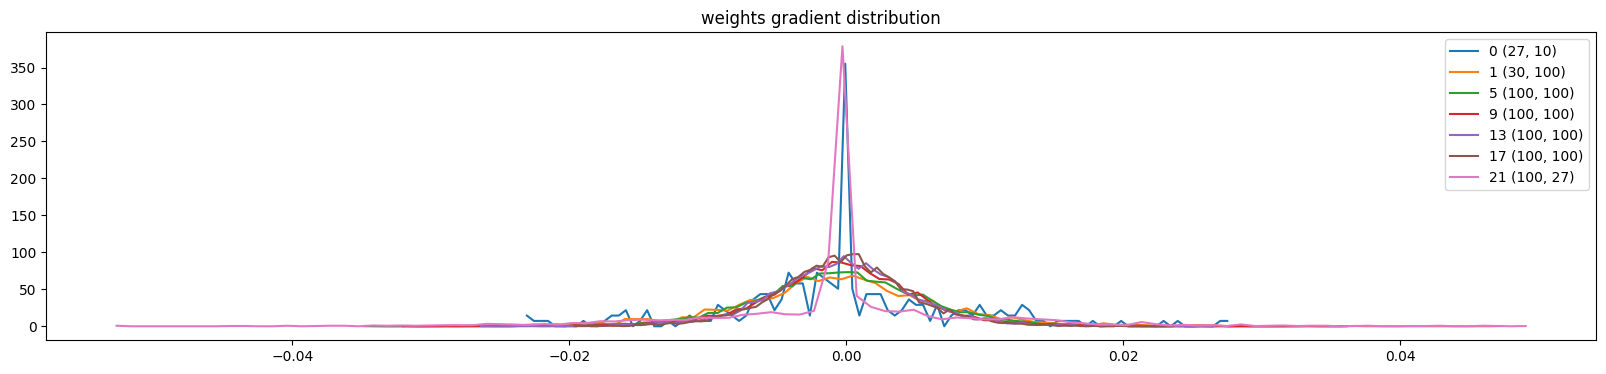

In [81]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:   # keeping only weights, skipped biases, gammas, betas
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

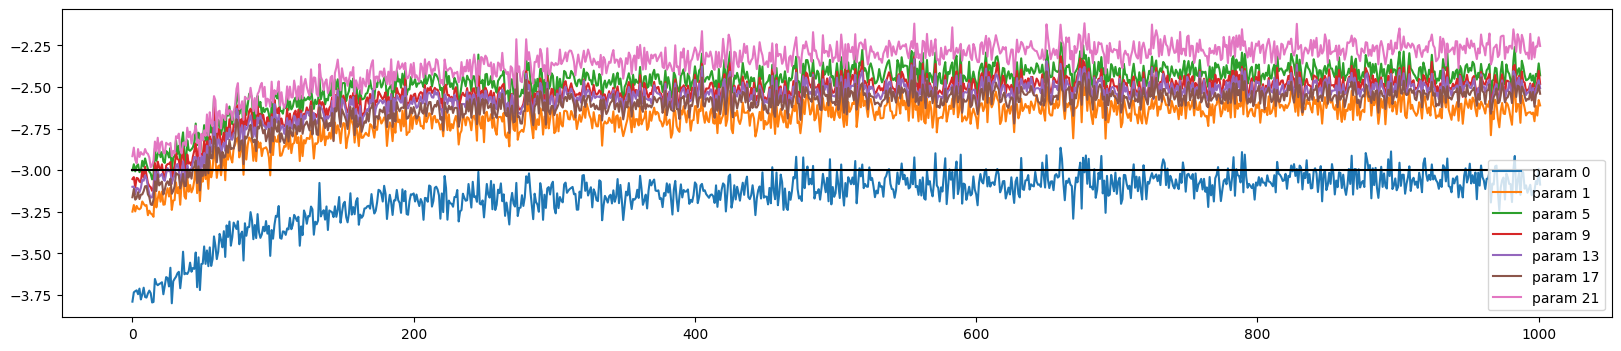

In [ ]:
# plotted with lr = 0.1 for 1000 iter
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# slightly above -3. all params are training roughly at the same rate.

gain = 0.2
activations are unaffected, gradients are fine, weight gradients are okay because of batch norm but the updates are changed.
the scale of the updates of paramas are changed.
so we don't get a free pass to set arbitrary gains/weights but it becomes more robust because of batchnorm in terms of fw, bw and weight gradients. may have to retrain the lr

layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 3.06%
layer 5 (      Tanh): mean +0.01, std 0.65, saturated: 1.81%
layer 8 (      Tanh): mean +0.01, std 0.66, saturated: 1.22%
layer 11 (      Tanh): mean -0.00, std 0.66, saturated: 0.81%
layer 14 (      Tanh): mean -0.00, std 0.67, saturated: 0.47%


Text(0.5, 1.0, 'activation distribution')

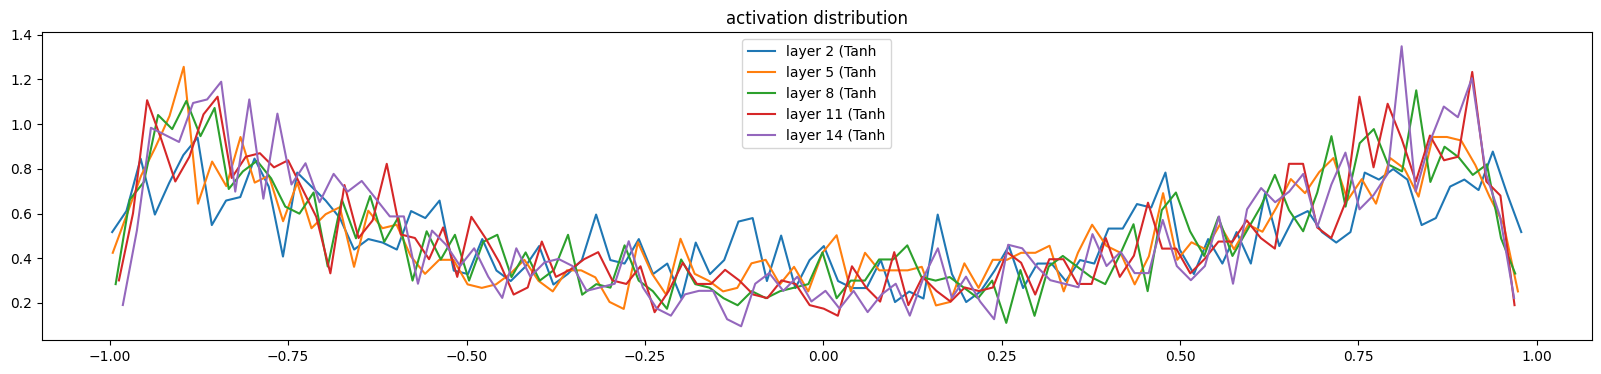

In [86]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean +0.000000, std 1.310603e-03
layer 5 (      Tanh): mean -0.000000, std 1.085275e-03
layer 8 (      Tanh): mean +0.000000, std 9.020567e-04
layer 11 (      Tanh): mean -0.000000, std 9.003510e-04
layer 14 (      Tanh): mean -0.000000, std 1.020395e-03


Text(0.5, 1.0, 'gradient distribution')

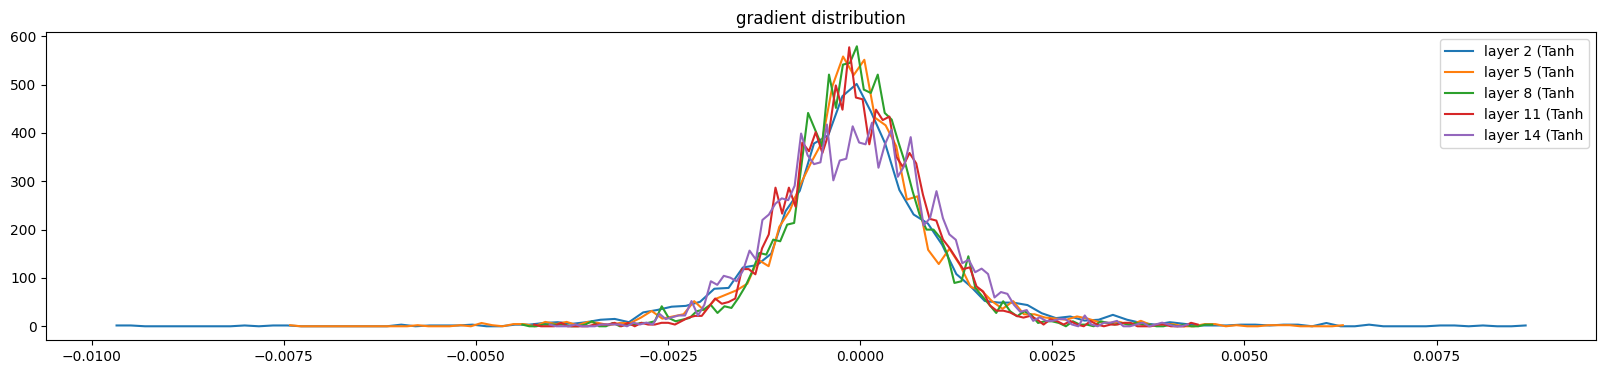

In [87]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 6.836006e-03 | grad:data ratio 6.829627e-03
weight  (30, 100) | mean +0.000323 | std 1.270320e-02 | grad:data ratio 2.090848e-01
weight (100, 100) | mean +0.000052 | std 5.490654e-03 | grad:data ratio 1.836527e-01
weight (100, 100) | mean +0.000060 | std 4.555569e-03 | grad:data ratio 1.663135e-01
weight (100, 100) | mean +0.000008 | std 4.137234e-03 | grad:data ratio 1.571064e-01
weight (100, 100) | mean -0.000004 | std 4.278831e-03 | grad:data ratio 1.641234e-01
weight  (100, 27) | mean -0.000036 | std 1.243381e-02 | grad:data ratio 2.882380e-01


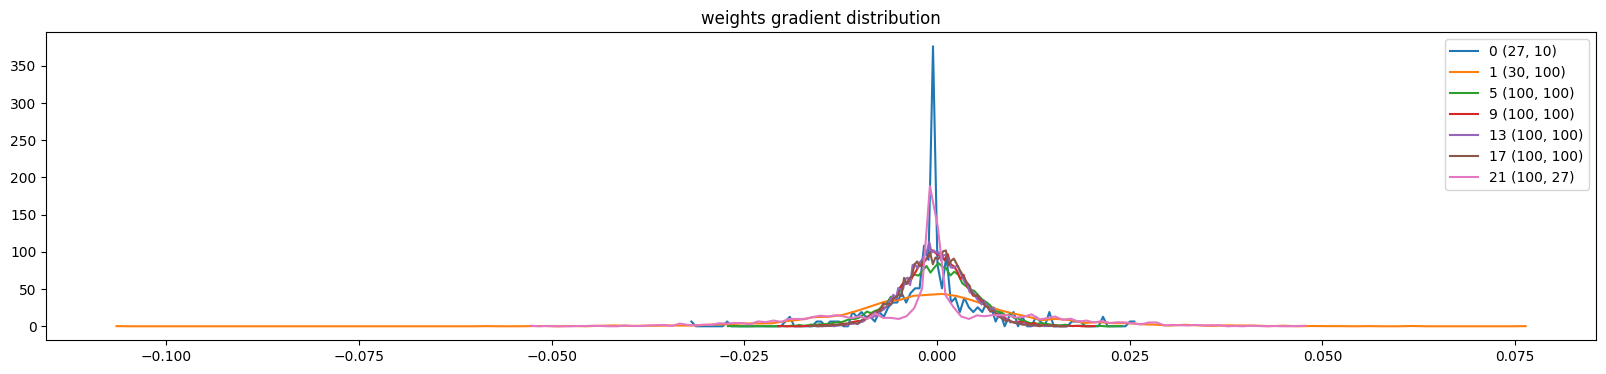

In [88]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:   # keeping only weights, skipped biases, gammas, betas
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

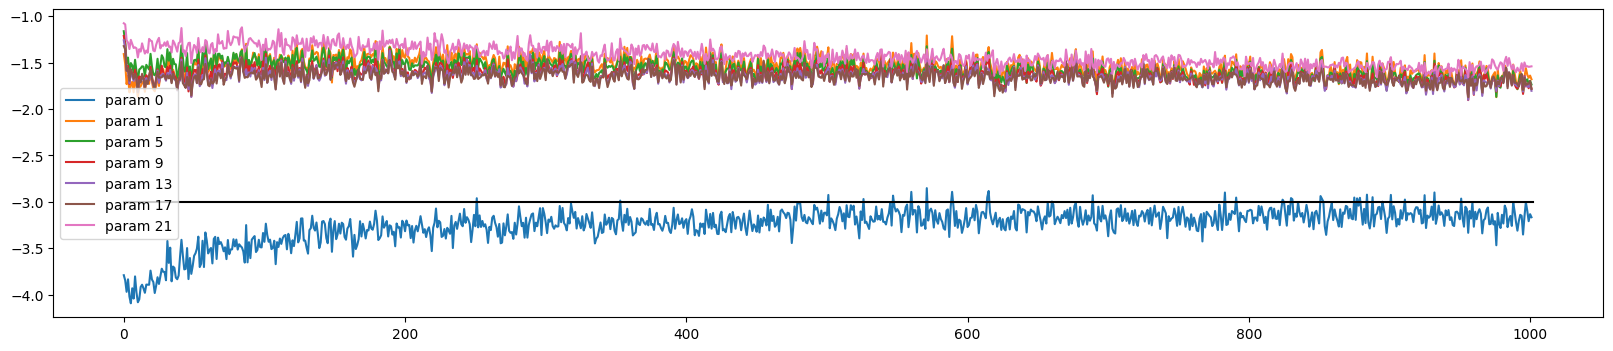

In [89]:
# plotted with lr = 0.1 for 1000 iter
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# slightly above -3. all params are training roughly at the same rate.

Ex1 - set all the weights and biases to 0

In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # self.weight = torch.randn((fan_in,fan_out),generator=g) / (fan_in ** 0.5)
        self.weight = torch.zeros(fan_in,fan_out)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps = 1e-5):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # batch normalization gain
        self.beta = torch.zeros(dim) # batch normalization bias
    
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)    # batch variance
        else:     # test or inference
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar+self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta   # scale and shift

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [23]:
n_hidden = 100
n_embd = 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [ 
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
        ]

with torch.no_grad():
    # last layer: make softmax less confident
    layers[-1].gamma *= 0.1

    # all other layers apply gain
    # note : this isn't doing anything now as the weights are initialized to 0 so multiplying by 5/3 doesn't change anything
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Number of total parameters: ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


Number of total parameters:  47551


In [ ]:
lossi=[]
batch_size = 32
max_steps = 200000
ud = []  # update to data ratio (stat to plot and check the update done to data)
for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0, X_tr.shape[0],(batch_size, ), generator=g)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # forward pass
    emb = C[Xb]   # embed the characters
    x = emb.view(emb.shape[0],-1)  #concatenate

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # DEBUG : remove later
    
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i>1000:
        break # DEBUG (visualizations below): remove later



0/200000 : 3.2958


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

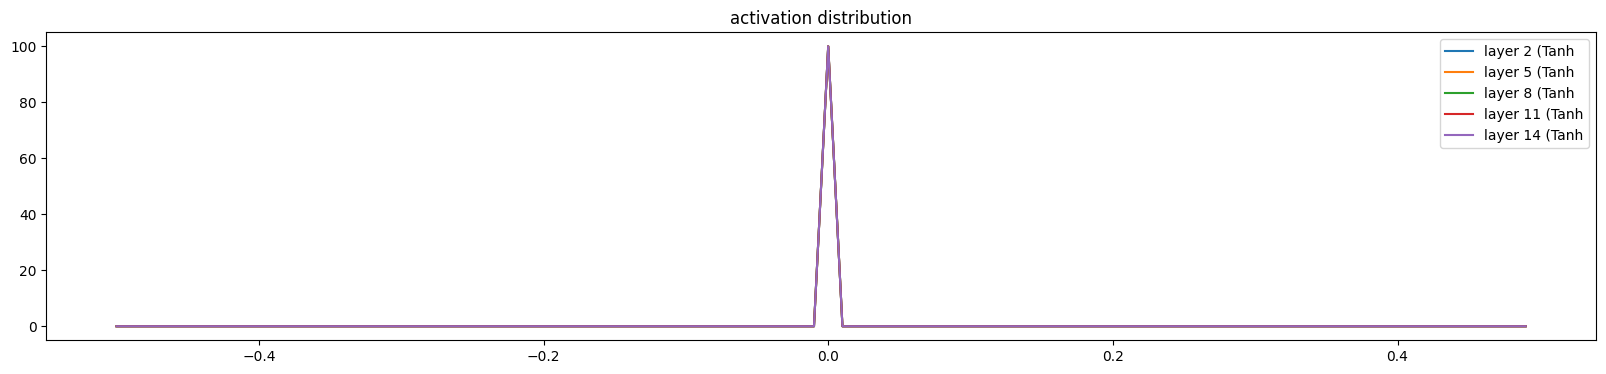

In [38]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
  
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

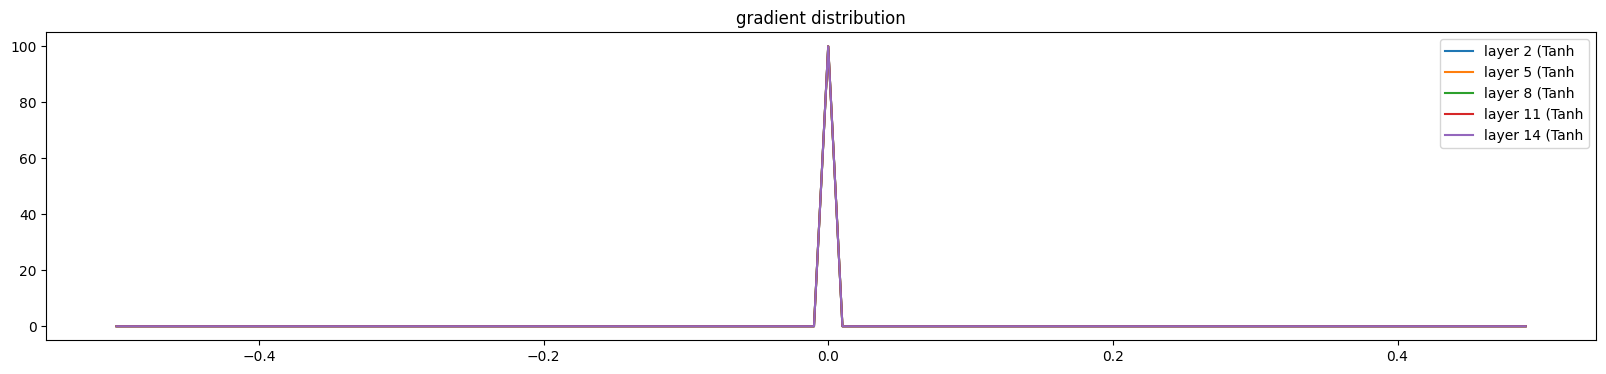

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

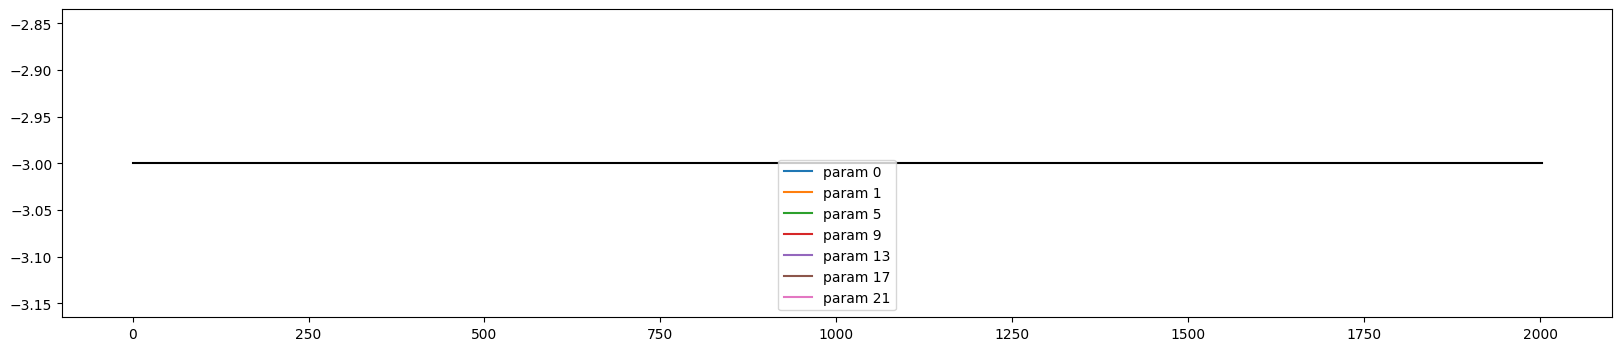

In [27]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

batchnorm fold - BatchNorm is an optimization trick for training stability; once training is done, its effect can be exactly absorbed into the preceding Linear layer and removed from inference.

https://medium.com/data-science/speed-up-inference-with-batch-normalization-folding-8a45a83a89d8

In [7]:
n_hidden = 100
n_embd = 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [ 
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
        ]

with torch.no_grad():
    # last layer: make softmax less confident
    # layers[-1].weight *= 0.1
    # now as the last layer is batchnorm, weights won't be changed. gamma would be.
    layers[-1].gamma *= 0.1

    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3  # can be 1 with batch norm

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('Number of total parameters: ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


Number of total parameters:  47551


In [8]:
lossi=[]
batch_size = 32
max_steps = 200000
ud = []  # update to data ratio (stat to plot and check the update done to data)
for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0, X_tr.shape[0],(batch_size, ), generator=g)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # forward pass
    emb = C[Xb]   # embed the characters
    x = emb.view(emb.shape[0],-1)  #concatenate

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # DEBUG : remove later
    
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i}/{max_steps} : {loss.item():.4f}')

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i>1000:
        break # DEBUG 



0/200000 : 3.2870


In [9]:
# BatchNorm in eval mode
for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

In [10]:
def fold_batchnorm(linear, bn):
    # linear layer params
    W = linear.weight          # (fan_in, fan_out)
    b = linear.bias if linear.bias is not None else torch.zeros(W.shape[1])

    # batchnorm layer params
    gamma = bn.gamma
    beta = bn.beta
    mean = bn.running_mean
    var = bn.running_var
    eps = bn.eps

    scale = gamma / torch.sqrt(var + eps)

    W_fused = W * scale
    b_fused = (b - mean) * scale + beta

    return W_fused, b_fused
    

fused_layers = []

i = 0
while i < len(layers):
    if isinstance(layers[i], Linear) and isinstance(layers[i+1], BatchNorm1d):
        W2, b2 = fold_batchnorm(layers[i], layers[i+1])

        fused = Linear(W2.shape[0], W2.shape[1])
        fused.weight = W2
        fused.bias = b2

        fused_layers.append(fused)
        i += 2  # skip BN
    else:
        fused_layers.append(layers[i])
        i += 1


In [11]:
@torch.no_grad()
def forward_bn(x):
    emb = C[x]
    x = emb.view(x.shape[0], -1)
    for layer in layers:
        x = layer(x)
    return x

@torch.no_grad()
def forward_fused(x):
    emb = C[x]
    x = emb.view(x.shape[0], -1)
    for layer in fused_layers:
        x = layer(x)
    return x

x_test = X_t[:32]

print(torch.allclose(
    forward_bn(x_test),
    forward_fused(x_test),
    atol=1e-5
))


True


Training uses BatchNorm for stability

Inference does not need BatchNorm

BatchNorm does not add representational power

It can be exactly removed after training

Training loop: unchanged

Inference graph: modified

Weights: algebraically fused

Outputs: identical